
# 🍲 Local Food Wastage Management — Upgraded Notebook (VS Code Jupyter)

**Owner:** Vrushabh Jadkar

This version fixes the issues you hit:
- Normalizes column names to lowercase (avoids `KeyError: 'city'`).
- Robust date handling using `pd.to_datetime(..., errors='coerce')`.
- Adds an `is_expired` flag **instead of dropping rows**, so analysis won’t go empty.
- Safe plotting (casts counts to numeric and guards against empty data).
- SQLite schema with foreign keys + checks and verification cells.
- CRUD helpers and 15+ analytical queries.

> Place your 4 CSVs next to this notebook or adjust `DATA_DIR` below.


In [1]:

# (Run if needed)
%pip install pandas matplotlib python-dateutil


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:

import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

# Paths
DATA_DIR = "./"
DB_PATH  = "./food_app.db"

# CSV files
PROVIDERS_CSV = os.path.join(DATA_DIR, "providers_data.csv")
RECEIVERS_CSV = os.path.join(DATA_DIR, "receivers_data.csv")
FOOD_CSV      = os.path.join(DATA_DIR, "food_listings_data.csv")
CLAIMS_CSV    = os.path.join(DATA_DIR, "claims_data.csv")

print("Using:", PROVIDERS_CSV, RECEIVERS_CSV, FOOD_CSV, CLAIMS_CSV, sep="\n- ")
print("DB:", DB_PATH)


Using:
- ./providers_data.csv
- ./receivers_data.csv
- ./food_listings_data.csv
- ./claims_data.csv
DB: ./food_app.db


In [2]:

# Utilities
def norm_city(x):
    if pd.isna(x): return None
    return str(x).strip().title()


In [3]:

# Load CSVs
providers = pd.read_csv(PROVIDERS_CSV)
receivers = pd.read_csv(RECEIVERS_CSV)
food_listings = pd.read_csv(FOOD_CSV)
claims = pd.read_csv(CLAIMS_CSV)

print("Before normalization:")
print("Providers:", providers.columns.tolist())
print("Receivers:", receivers.columns.tolist())
print("Food listings:", food_listings.columns.tolist())
print("Claims:", claims.columns.tolist())

# Normalize columns to lowercase (prevents KeyError: 'city')
providers.columns = providers.columns.str.strip().str.lower()
receivers.columns = receivers.columns.str.strip().str.lower()
food_listings.columns = food_listings.columns.str.strip().str.lower()
claims.columns = claims.columns.str.strip().str.lower()

print("\nAfter normalization:")
print("Providers:", providers.columns.tolist())
print("Receivers:", receivers.columns.tolist())
print("Food listings:", food_listings.columns.tolist())
print("Claims:", claims.columns.tolist())


Before normalization:
Providers: ['Provider_ID', 'Name', 'Type', 'Address', 'City', 'Contact']
Receivers: ['Receiver_ID', 'Name', 'Type', 'City', 'Contact']
Food listings: ['Food_ID', 'Food_Name', 'Quantity', 'Expiry_Date', 'Provider_ID', 'Provider_Type', 'Location', 'Food_Type', 'Meal_Type']
Claims: ['Claim_ID', 'Food_ID', 'Receiver_ID', 'Status', 'Timestamp']

After normalization:
Providers: ['provider_id', 'name', 'type', 'address', 'city', 'contact']
Receivers: ['receiver_id', 'name', 'type', 'city', 'contact']
Food listings: ['food_id', 'food_name', 'quantity', 'expiry_date', 'provider_id', 'provider_type', 'location', 'food_type', 'meal_type']
Claims: ['claim_id', 'food_id', 'receiver_id', 'status', 'timestamp']


In [4]:

# Cleaning
providers["city"]  = providers["city"].map(norm_city)
receivers["city"]  = receivers["city"].map(norm_city)
food_listings["location"] = food_listings["location"].map(norm_city)

# Ensure numeric
for col in ["provider_id", "receiver_id", "food_id", "quantity"]:
    if col in food_listings.columns:
        food_listings[col] = pd.to_numeric(food_listings[col], errors="coerce")
    if col in providers.columns:
        providers[col] = pd.to_numeric(providers[col], errors="coerce")
    if col in receivers.columns:
        receivers[col] = pd.to_numeric(receivers[col], errors="coerce")
    if col in claims.columns:
        claims[col] = pd.to_numeric(claims[col], errors="coerce")

# Date handling
food_listings["expiry_date"] = pd.to_datetime(food_listings["expiry_date"], errors="coerce")
claims["timestamp"] = pd.to_datetime(claims.get("timestamp", pd.NaT), errors="coerce")

# Add is_expired flag (don't drop rows)
TODAY = pd.to_datetime("today").normalize()
food_listings["is_expired"] = food_listings["expiry_date"] < TODAY

# Status normalization
if "status" in claims.columns:
    claims["status"] = claims["status"].astype(str).str.strip().str.title()

# Basic sanity
print("Rows after cleaning -> providers/receivers/food/claims:",
      len(providers), len(receivers), len(food_listings), len(claims))


Rows after cleaning -> providers/receivers/food/claims: 1000 1000 1000 1000


In [5]:

# SQLite schema with FKs & checks
schema_sql = """
PRAGMA foreign_keys = ON;

CREATE TABLE IF NOT EXISTS providers (
  provider_id   INTEGER PRIMARY KEY,
  name          TEXT NOT NULL,
  type          TEXT,
  address       TEXT,
  city          TEXT,
  contact       TEXT
);

CREATE TABLE IF NOT EXISTS receivers (
  receiver_id   INTEGER PRIMARY KEY,
  name          TEXT NOT NULL,
  type          TEXT,
  city          TEXT,
  contact       TEXT
);

CREATE TABLE IF NOT EXISTS food_listings (
  food_id       INTEGER PRIMARY KEY,
  food_name     TEXT NOT NULL,
  quantity      INTEGER CHECK (quantity >= 0),
  expiry_date   TEXT,
  provider_id   INTEGER REFERENCES providers(provider_id) ON DELETE CASCADE,
  provider_type TEXT,
  location      TEXT,
  food_type     TEXT,
  meal_type     TEXT,
  is_expired    INTEGER CHECK (is_expired IN (0,1))
);

CREATE TABLE IF NOT EXISTS claims (
  claim_id      INTEGER PRIMARY KEY,
  food_id       INTEGER REFERENCES food_listings(food_id) ON DELETE CASCADE,
  receiver_id   INTEGER REFERENCES receivers(receiver_id) ON DELETE CASCADE,
  status        TEXT,
  timestamp     TEXT
);
"""

con = sqlite3.connect(DB_PATH)
cur = con.cursor()
cur.executescript(schema_sql)
con.commit()
con.close()
print("Schema created at", DB_PATH)


Schema created at ./food_app.db


In [6]:

# Insert (replace to make re-runs idempotent)
with sqlite3.connect(DB_PATH) as con:
    con.execute("PRAGMA foreign_keys = ON;")
    providers.to_sql("providers", con, if_exists="replace", index=False)
    receivers.to_sql("receivers", con, if_exists="replace", index=False)
    food_listings.to_sql("food_listings", con, if_exists="replace", index=False)
    claims.to_sql("claims", con, if_exists="replace", index=False)

print("Data inserted ✅")


Data inserted ✅


In [7]:

# Verify DB contents
with sqlite3.connect(DB_PATH) as con:
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", con)
    print("Tables:", tables["name"].tolist())
    for tbl in ["providers","receivers","food_listings","claims"]:
        try:
            cnt = pd.read_sql_query(f"SELECT COUNT(*) AS rows FROM {tbl};", con)["rows"][0]
            print(f"- {tbl}: {cnt} rows")
        except Exception as e:
            print(f"- {tbl}: error ->", e)


Tables: ['providers', 'receivers', 'food_listings', 'claims']
- providers: 1000 rows
- receivers: 1000 rows
- food_listings: 1000 rows
- claims: 1000 rows


In [8]:

# SQL helper
def run_sql(query, params=None):
    if params is None: params = {}
    with sqlite3.connect(DB_PATH) as con:
        return pd.read_sql_query(query, con, params=params)


In [9]:

# ---- 15+ Analysis Queries ----

# 1. Providers per city
display(run_sql("SELECT city, COUNT(*) AS providers FROM providers GROUP BY city ORDER BY providers DESC"))

# 2. Receivers per city
display(run_sql("SELECT city, COUNT(*) AS receivers FROM receivers GROUP BY city ORDER BY receivers DESC"))

# 3. Food per provider_type
display(run_sql("SELECT provider_type, SUM(quantity) AS total_qty FROM food_listings GROUP BY provider_type ORDER BY total_qty DESC"))

# 4. Claims per status
display(run_sql("SELECT status, COUNT(*) AS total FROM claims GROUP BY status ORDER BY total DESC"))

# 5. City with most listings (including expired)
display(run_sql("SELECT location, COUNT(*) AS listings FROM food_listings GROUP BY location ORDER BY listings DESC"))

# 6. Active (non-expired) listings by city
display(run_sql("SELECT location, COUNT(*) AS active_listings FROM food_listings WHERE IFNULL(is_expired,0)=0 GROUP BY location ORDER BY active_listings DESC"))

# 7. Most common food types
display(run_sql("SELECT food_type, COUNT(*) AS cnt FROM food_listings GROUP BY food_type ORDER BY cnt DESC"))

# 8. Claims per food item
display(run_sql("SELECT food_id, COUNT(*) AS claims FROM claims GROUP BY food_id ORDER BY claims DESC"))

# 9. Provider with most completed claims
display(run_sql("""SELECT p.provider_id, p.name, COUNT(*) AS successful_claims
FROM claims c
JOIN food_listings f ON f.food_id = c.food_id
JOIN providers p ON p.provider_id = f.provider_id
WHERE c.status = 'Completed'
GROUP BY p.provider_id, p.name
ORDER BY successful_claims DESC
"""))

# 10. Claim status percentages
display(run_sql("""SELECT status,
       ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM claims), 2) AS pct
FROM claims
GROUP BY status
ORDER BY pct DESC
"""))

# 11. Avg quantity per receiver (based on claimed food quantities)
display(run_sql("""SELECT r.receiver_id, r.name, AVG(f.quantity) AS avg_quantity_seen
FROM claims c
JOIN receivers r ON r.receiver_id = c.receiver_id
JOIN food_listings f ON f.food_id = c.food_id
GROUP BY r.receiver_id, r.name
ORDER BY avg_quantity_seen DESC
"""))

# 12. Most claimed meal type
display(run_sql("""SELECT f.meal_type, COUNT(*) AS claims
FROM claims c
JOIN food_listings f ON f.food_id = c.food_id
GROUP BY f.meal_type
ORDER BY claims DESC
"""))

# 13. Total quantity donated by provider
display(run_sql("""SELECT p.provider_id, p.name, SUM(f.quantity) AS total_donated
FROM providers p
JOIN food_listings f ON f.provider_id = p.provider_id
GROUP BY p.provider_id, p.name
ORDER BY total_donated DESC
"""))

# 14. Listings expiring in next N days (default 7)
N = 7
display(run_sql("SELECT * FROM food_listings WHERE date(expiry_date) BETWEEN date('now') AND date('now', '+' || :n || ' days') ORDER BY expiry_date", {"n": N}))

# 15. High-demand cities (by number of claims)
display(run_sql("""SELECT f.location AS city, COUNT(*) AS total_claims
FROM claims c
JOIN food_listings f ON f.food_id = c.food_id
GROUP BY f.location
ORDER BY total_claims DESC
"""))


,city,providers
0,South Christopherborough,3
1,New Carol,3
2,Williamview,2
3,West Lauraborough,2
4,West Christopher,2
...,...,...
958,Alexanderchester,1
959,Aguirreville,1
960,Adamsville,1
961,Adamsview,1


,city,receivers
0,New Christopher,3
1,Williamsfort,2
2,West Richard,2
3,West James,2
4,Stevenmouth,2
...,...,...
961,Alexanderbury,1
962,Aguilarstad,1
963,Aguilarbury,1
964,Adamland,1


,provider_type,total_qty
0,Restaurant,6923
1,Supermarket,6696
2,Catering Service,6116
3,Grocery Store,6059


,status,total
0,Completed,339
1,Cancelled,336
2,Pending,325


,location,listings
0,South Kathryn,6
1,New Carol,6
2,Perezport,5
3,Jimmyberg,5
4,East Angela,5
...,...,...
619,Andersonmouth,1
620,Amandashire,1
621,Allenborough,1
622,Alexanderchester,1


,location,active_listings


,food_type,cnt
0,Vegetarian,336
1,Vegan,334
2,Non-Vegetarian,330


,food_id,claims
0,548,5
1,486,5
2,463,5
3,981,4
4,925,4
...,...,...
642,13,1
643,11,1
644,7,1
645,6,1


,provider_id,name,successful_claims
0,709,Barry Group,5
1,241,"Harper, Blake and Alexander",4
2,596,"Barnes, Castro and Curtis",4
3,752,Butler-Richardson,4
4,967,Miller Inc,4
...,...,...,...
246,983,"Munoz, Stone and Wallace",1
247,985,Frey PLC,1
248,995,Moore Group,1
249,998,Novak Group,1


,status,pct
0,Completed,33.9
1,Cancelled,33.6
2,Pending,32.5


,receiver_id,name,avg_quantity_seen
0,99,Nancy Silva,50.0
1,282,Lisa Pitts,50.0
2,429,Daniel Williams,50.0
3,567,Peggy Knight,50.0
4,616,Christopher Wright,50.0
...,...,...,...
619,214,Corey Rodriguez,2.0
620,746,Kenneth Barnes,2.0
621,766,John Reynolds,2.0
622,765,Joshua Hooper,1.0


,meal_type,claims
0,Breakfast,278
1,Lunch,250
2,Snacks,240
3,Dinner,232


,provider_id,name,total_donated
0,709,Barry Group,179
1,306,"Evans, Wright and Mitchell",158
2,655,Smith Group,150
3,315,Nelson LLC,142
4,678,Ruiz-Oneal,140
...,...,...,...
632,258,Gonzales-Moore,1
633,745,"Martinez, Armstrong and Carroll",1
634,849,Brown and Sons,1
635,870,Mcgee PLC,1


,food_id,food_name,quantity,expiry_date,provider_id,provider_type,location,food_type,meal_type,is_expired


,city,total_claims
0,East Heatherport,12
1,Lake Andrewmouth,9
2,Jamesfurt,9
3,South Kathryn,7
4,New Carol,7
...,...,...
463,Anthonyshire,1
464,Anthonyborough,1
465,Andersonville,1
466,Amandashire,1


In [10]:

# ---- CRUD Helpers ----
def add_provider(provider_id, name, type_, address, city, contact):
    sql = "INSERT INTO providers (provider_id, name, type, address, city, contact) VALUES (?,?,?,?,?,?)"
    with sqlite3.connect(DB_PATH) as con:
        con.execute(sql, (int(provider_id), name, type_, address, city, contact))
        con.commit()

def update_listing_quantity(food_id, new_qty):
    sql = "UPDATE food_listings SET quantity=? WHERE food_id=?"
    with sqlite3.connect(DB_PATH) as con:
        con.execute(sql, (int(new_qty), int(food_id)))
        con.commit()

def delete_listing(food_id):
    sql = "DELETE FROM food_listings WHERE food_id=?"
    with sqlite3.connect(DB_PATH) as con:
        con.execute(sql, (int(food_id),))
        con.commit()

def create_claim(claim_id, food_id, receiver_id, status='Pending', timestamp=None):
    if timestamp is None:
        sql = "INSERT INTO claims (claim_id, food_id, receiver_id, status) VALUES (?,?,?,?)"
        params = (int(claim_id), int(food_id), int(receiver_id), status)
    else:
        sql = "INSERT INTO claims (claim_id, food_id, receiver_id, status, timestamp) VALUES (?,?,?,?,?)"
        params = (int(claim_id), int(food_id), int(receiver_id), status, timestamp)
    with sqlite3.connect(DB_PATH) as con:
        con.execute(sql, params)
        con.commit()

def update_claim_status(claim_id, new_status):
    sql = "UPDATE claims SET status=? WHERE claim_id=?"
    with sqlite3.connect(DB_PATH) as con:
        con.execute(sql, (new_status, int(claim_id)))
        con.commit()

print("CRUD helpers ready.")


CRUD helpers ready.


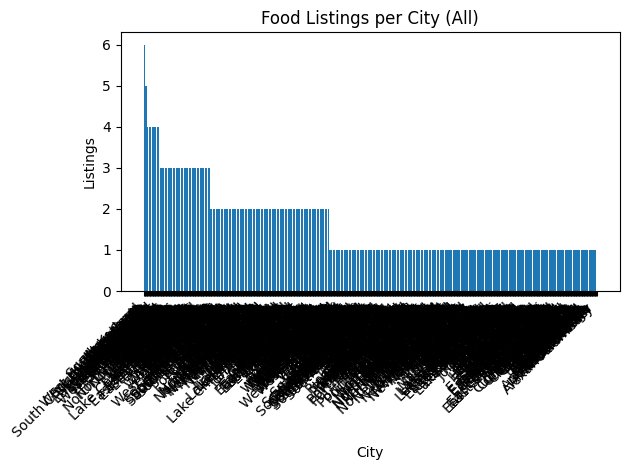

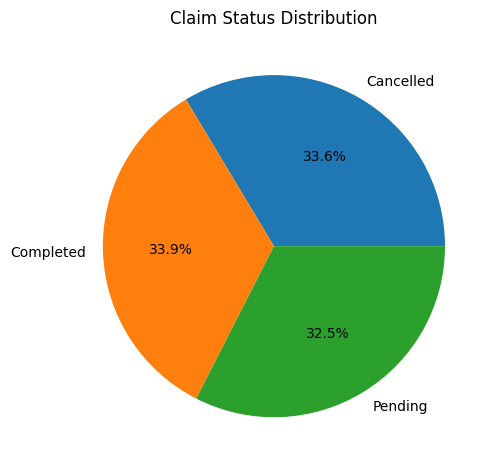

In [11]:

# ---- Visualizations (safe casting & empty-guard) ----

# 1) Listings per city (all)
df = run_sql("SELECT location, COUNT(*) AS cnt FROM food_listings GROUP BY location ORDER BY cnt DESC")
if not df.empty:
    df["cnt"] = pd.to_numeric(df["cnt"], errors="coerce").fillna(0)
    plt.figure()
    plt.bar(df["location"], df["cnt"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Food Listings per City (All)")
    plt.xlabel("City")
    plt.ylabel("Listings")
    plt.tight_layout()
    plt.show()
else:
    print("No data for listings per city.")

# 2) Claim status distribution
df2 = run_sql("SELECT status, COUNT(*) AS cnt FROM claims GROUP BY status")
if not df2.empty:
    df2["cnt"] = pd.to_numeric(df2["cnt"], errors="coerce").fillna(0)
    plt.figure()
    plt.pie(df2["cnt"], labels=df2["status"], autopct="%1.1f%%")
    plt.title("Claim Status Distribution")
    plt.tight_layout()
    plt.show()
else:
    print("No claims data to plot.")



## ✅ Done
- If any chart prints "No data", check your CSV contents or remove filters.
- Next, we can wire this DB to a **Streamlit** app with search & claim flows.
